## Keras Layered Model & Explorations - JoanieW

Based on the following tutorial: https://elix-tech.github.io/ja/2016/06/02/kaggle-facial-keypoints-ja.html#conv

And modeled after Jackie's code structure for Lenet5

### Model Description
- Convolutional NN with 3 convolutional layers, 3 normalization layers, and 2 fully connected layers
- Performed maximum pooling of 2x2 after each convolutional layer
- ‘Relu’ activation function
- Adam optimizer - stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments and recommended for CNN. Did try SGD at first but saw improvement with Adam


### Best Score

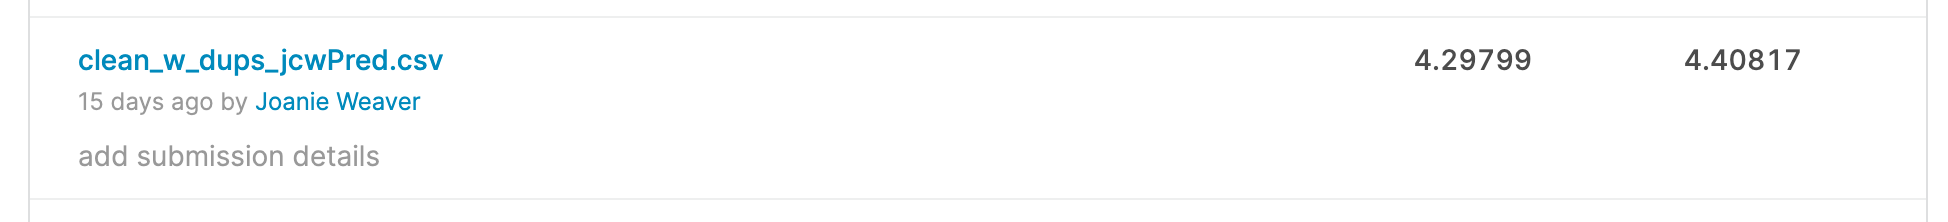

The best score for the base version of this model is above. The base version predicted 30 keypoints and used batchnormalization.

In [ ]:
#Set the utils path to point to the utils directory locally
UTILS_PATH = "utils/"

import os, sys
sys.path.append(UTILS_PATH)
from load_models import LoadTrainModels
from predict_models import PredictModels
from transform_data import TransformData
import imp
import pickle
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, model_from_json

In [ ]:
cd ..

In [ ]:
### this is gold right here.
file_path = "cleantrain/"
trainer = LoadTrainModels("data/models/", file_path)
trainer.print_paths()

### For every version of a clean Train file in a given path, create and save a model

The following cell is a base version.  No transformations to the data were applied and all layers were used from the model.
The following cell produced the prediction with the best result for the clean file named: clean_all_outliers.  This means that the train file that was cleaned by removing all outliers produced the best result with these settings. 

This cell looped through the directory of clean trail files which appears below and created a model for each file. Please refer to the Readme file for more information on each.

In [ ]:

files = os.listdir(file_path)

#For every version of a cleaned Train file in CleanTrain directory, create and save a model
for filename in files: 
    print("Opening file: ", filename)
    clean_file = "".join((file_path,filename))
    print(clean_file)
    train_data = pickle.load( open( clean_file, "rb" ) )
    train_data = train_data.drop(['level_0', 'check_sum', 'index'], axis=1,errors='ignore')
    print("Train Shape:", train_data.shape)

    filename = str(filename).replace('.p', '').strip()
    print("Begin model and train:")
    model_name = "".join((filename,"_jcw"))
    print("Model name:", model_name)
    #Run with separate = True to train on 8 columns of data
    model, history = trainer.train_model(model_name, train_data,verbose = True)
    print("End model and train")    
    print()

### For every model file in a given path, predict using the model and save the predictions in CSV file

In [ ]:
#Getting the prediction information from the id_lookup table and the test list of images
id_lookup = pickle.load( open( "data/id_lookup.p", "rb" ) )
test = pickle.load( open( "data/test.p", "rb" ) )

#Using local paths as this is way faster...
file_path = "data/models/"
pred_path = "data/predictions/"

predictor = PredictModels(file_path,pred_path , id_lookup)

predictor.print_paths()

files = os.listdir(file_path)
#For every model in file_path, predict using the model and save the predictions in CSV file
for filename in files:
    if ".h5" in filename:
        base_name = filename[:-3]
        model_json = ''.join((base_name,".json"))
        print("Working with: ", base_name)
        print("Begin Predict")
        #Set columns = False if only predicting 8 keypoints
        Y= predictor.predict_standard(base_name, filename, model_json, test, columns=False)
        print("End model and train")    
        print()


## Explorations on using different models for 8 vs. 30 predictions

As we showed in the EDA, the majority of the test cases only require 8 keypoints to be predicted. Using the code at the end, I ran each of our group's 3 models with the last layer only predicting 8 keypoints instead of 30.

For the test cases that still needed 30, I took the predictions from an earlier predictions file for that corresponding model and clean training set.

The code immediately following was used for explorations to determine where/how to split the predictions for 8 vs. 30.

In [ ]:
#Load the id_lookup and test

id_lookup = pickle.load( open( "data/id_lookup.p", "rb" ) )
test = pickle.load( open( "data/test.p", "rb" ) )

In [ ]:
#Filtering to ids where image_id count == 8
#These ids only require 8 keypoints
new_id = id_lookup.groupby("image_id").agg('count')
new_id_2 = new_id[new_id[ "row_id" ] <= 8]
new_id_1 = new_id[new_id[ "row_id" ] > 8]
print(new_id_2.index)
print(new_id_1.index)


In [ ]:
#Separating into groups based on the index that separates 30 keypoints vs 8 keypoints
id_lookup_1 = id_lookup[id_lookup['image_id']<=591]
id_lookup_2 = id_lookup[id_lookup['image_id'] > 591]

In [ ]:
test_1 = test[test['image_id']<=591]
test_1

In [ ]:
test_2 = test[test['image_id']>591]
test_2

In [ ]:
#Identify where in the id_lookup is the last output row
print(np.max(id_lookup_1['row_id']))
print(np.min(id_lookup_1['row_id']))

max_row_full = np.max(id_lookup_1['row_id'])

The first 591 rows of the id lookups require more than 8 keypoints. Afterwards the next 1192 rows only require 6 or 8 keypoints.

In [ ]:
id_lookup = id_lookup_2
test = test_2
pred_path = "data/predictions/"

predictor = PredictModels(file_path,pred_path , id_lookup)

model_json = "data/models/clean_w_outliers_jcw.json"
model_file = "data/models/clean_w_outliers_jcw.h5"
json_file = open(model_json, "r")
model_json_data = json_file.read()
json_file.close()
model = model_from_json(model_json_data)
model.load_weights(model_file)
base_name = "clean_w_outliers_jcw"
filename = model_file
Y= predictor.predict_standard(base_name, filename, model_json, test)

In [ ]:
cd intro_ml/blackboxes/

## Reading in prediction csvs to combine to make final prediction file

The following code is used to read in the predictions that were made based on 8 keypoints and append information for test cases that required 30 keypoints from a previous prediction file.

In [ ]:
file_path = "data/predictions/"
files = os.listdir(file_path)

for file in files:
    #separate is from the most recent run of predictions based solely on train data that had 8 keypoints
    predictions_separate= pd.read_csv("data/predictions/"+file)
    #full is the older predictions data that was built on all the train
    predictions_full = pd.read_csv("data/predictions_full/"+file)
    new_pred = predictions_separate[predictions_separate['RowId']>max_row_full].copy()
    new_pred = new_pred.append(predictions_full[predictions_full['RowId']<=max_row_full].copy())
    new_pred = new_pred.sort_values(by=['RowId'])
    new_pred.to_csv("combined_"+file,index=False)
    

### Best Scores
The following top three scores were created using this combining method from models predictions 8 keypoints and 30 keypoints.

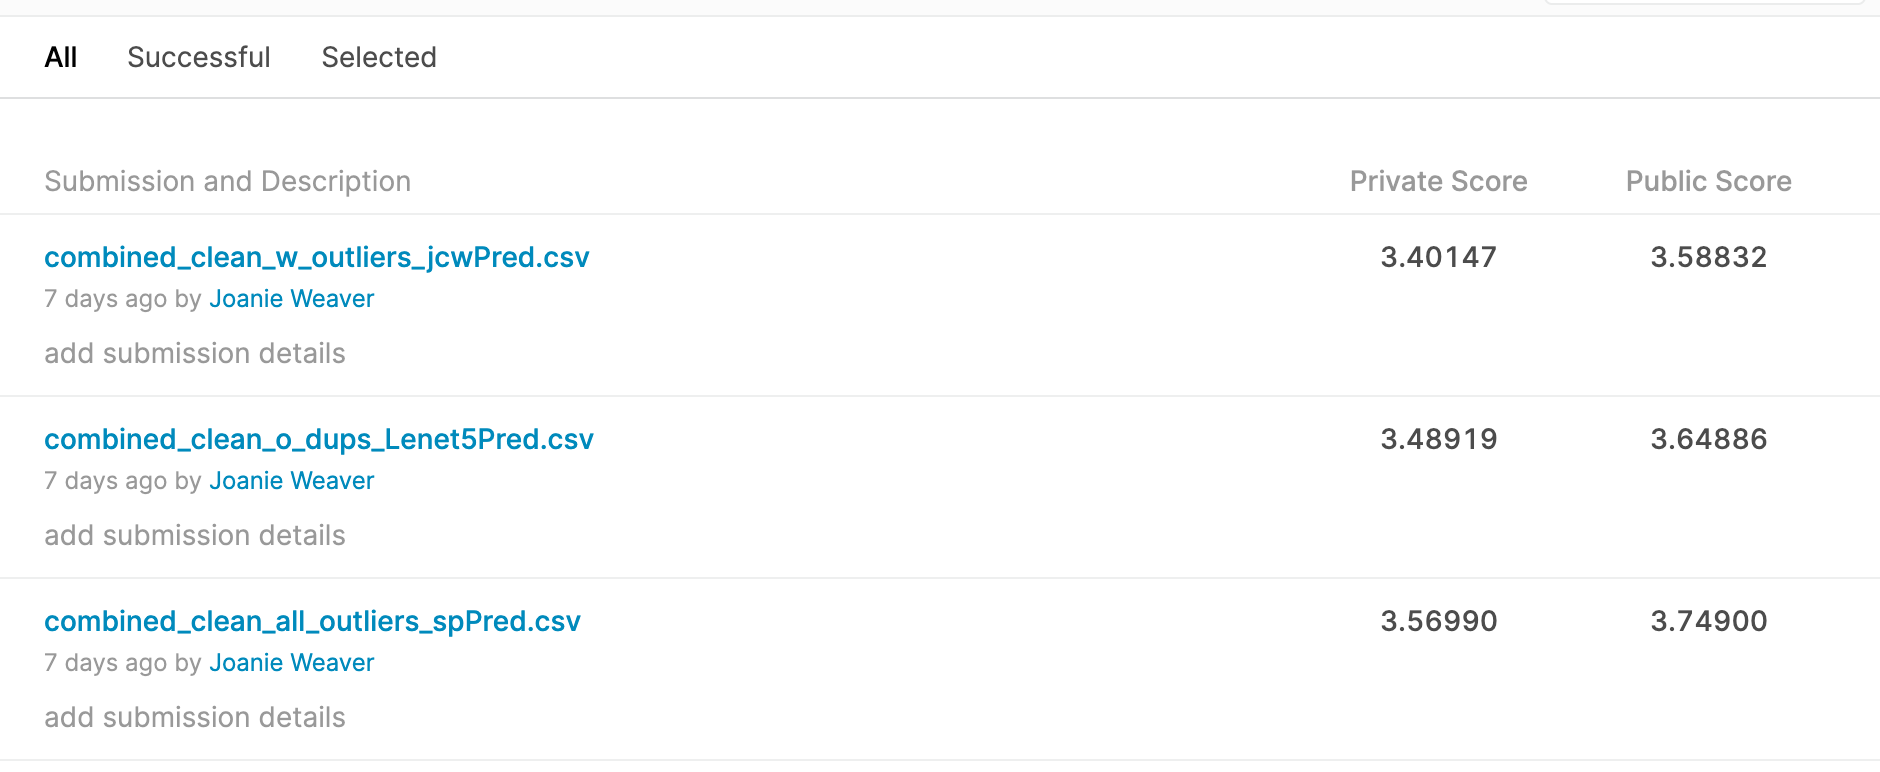